# Proyecto Final: Los Michis

# Modelo de prediccion de riesgo de Diabetes

## Importación de Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Configuración de pandas para mostrar todas las filas
pd.set_option('display.max_rows', None)


## Recolección de Datos.


In [2]:
# Carga de los datasets
df0 = pd.read_csv(
    "./Datasets/ensadul2022_entrega_w.csv",
    delimiter=";",
    low_memory=False,
)
df1 = pd.read_csv(
    "./Datasets/ensaantro2022.csv",
    delimiter=";",
    low_memory=False,
)
df2 = pd.read_csv(
    "./Datasets/Determinaciones_bioquímicas_cronicas_deficiencias.csv",
    delimiter=";",
    low_memory=False,
)
df3 = pd.read_csv(
    "./Datasets/ensafisica2022.csv",
    delimiter=";",
    low_memory=False,
)

# Selección de columnas de interés
df0_selected_columns = ["FOLIO_INT", "a0301"]  # Folio de la persona, Diabetes

df1_selected_columns = [
    "FOLIO_INT",    # Folio de la persona
    "an01_1",       # Peso de la persona
    "an01_2",       # Peso de la persona de __ anios a __ anios segunda medición
    "an04_1",       # Estatura de la persona de __ anios a __ anios primera medicion
    "an08_2",       # Cintura de la persona segunda medición
    "an12_1",       # Peso de la persona de __ anios a __ anios primera medición
    "an15_1",       # Estatura de la persona de __ anios a __ anios primera medición
    "an17_1",       # Distancia entre rodilla y talon
    "an21_1",       # Cintura de la persona primera medición
]

df2_selected_columns = [
    "FOLIO_INT",        # Folio de la persona
    "h0302",            # Sexo
    "h0303",            # Edad
    "valor_HB1AC",      # Hemoglobina glicosilada
    "hb02",             # Concentracion de Hemoglobina (Hemocue)
    "valor_AC_URICO",   # Acido urico
    "valor_GLU_SUERO",  # Resultado Glucosa en mg/dl
    "valor_INSULINA",   # Insulina en micho UI/ml
    "valor_TRIG",       # Trigliceridos
    "valor_EAG",        # Glucosa promedio estimada mg/dl
    "valor_VIT_B12",    # Vitamina B12 pg/mL
]

df3_selected_columns = [
    "FOLIO_INT",    # Folio de la persona
    "fa0400",       # Cuantas horas duerme en promedio en un dia
    "fa0401",       # CUantoos dias realizo una actividad que  requiere esfuerzo vigoroso
    "fa0403",       # Cuantos dias realizo una actividad fisica moderada
    "fa0405",       # Cuantos dias camino por lo menos 10 minutos continuos
    "fa0407h",      # Cuantas horas estuvo sentado los ultimos 7 dias de la semana
    "fa0408",       # Cuantos dias se desplazo en vehiculo de motor
    "fa0409h",      # Cuanto tiempo en horas paso viajando en transporte publico
    "fa0409m",      # tiempo en minutos
    "fa0410",       # Entre semana, cuantas horas pasa frente a una pantalla
    "fa0411",       # En fin de semana, cuantas horas pasa frente a una pantalla
    "fa0412",       # Entre semana, cuntas horas pasa frente a una pantalla jugando videojuegos
    "fa0413",       # En fin de semana, cuantas horas pasa frente a una pantalla jugando videojuegos
    "fa0414",       # Entre semana, cuantas horas pasa frente a un dispositivo movil
    "fa0415",       # En fin de semana, cuantas horas pasa frente a un dispositivo movil
]

# Union de los datasets por el campo FOLIO_INT
merged_df = pd.merge(
    df0[df0_selected_columns], df1[df1_selected_columns], on="FOLIO_INT", how="inner"
)
merged_df = pd.merge(merged_df, df2[df2_selected_columns], on="FOLIO_INT", how="inner")
merged_df = pd.merge(merged_df, df3[df3_selected_columns], on="FOLIO_INT", how="inner")

merged_df.drop(merged_df[merged_df["a0301"] == 2].index, inplace=True)
merged_df["a0301"] = pd.factorize(merged_df["a0301"])[0]

## Preprocesamiento de Datos

In [3]:
# limpieza de datos
merged_df.replace(r"^\s*$", np.nan, regex=True, inplace=True)
null_count = merged_df.isnull().sum()
print("\n Cantidad de nulos",null_count)

# Generación de archivo csv con variables seleccionadas
merged_df.to_csv(
    "./Datasets/Pd.csv",
    index=False,
)

# Cambiar datos de tipo string a numericos
columns_to_convert = [
    "hb02",
    "valor_AC_URICO",
    "valor_GLU_SUERO",
    "valor_INSULINA",
    "valor_TRIG",
    "valor_EAG",
    "valor_HB1AC",
    "valor_VIT_B12",
    "an01_1",
    "an01_2",
    "an04_1",
    "an08_2",
    "an12_1",
    "an15_1",
    "an17_1",
    "an21_1",
]

merged_df[columns_to_convert] = merged_df[columns_to_convert].apply(
    pd.to_numeric, errors="coerce"
)

merged_df[columns_to_convert] = merged_df[columns_to_convert].astype(float)

# Llenar valores nulos con knn e imputacion columna por columna
imputer = KNNImputer(n_neighbors=5)

for column in merged_df.columns:
    column_values = merged_df[[column]]
    imputed_column_values = imputer.fit_transform(column_values).ravel()
    merged_df[column] = imputed_column_values

null_count2 = merged_df.isnull().sum()
# print("\n Cantidad de nulos post llenado: ", null_count2)

# Eliminar registros duplicados
cantidad_duplicados = merged_df.duplicated().sum()
if cantidad_duplicados > 0:
    print("total de registros duplicados: ", cantidad_duplicados)
    duplicados = merged_df[merged_df.duplicated()]
    print("Registros duplicados:", duplicados)
    merged_df.drop_duplicates(inplace=True)
else:
    print("\n No hay registros duplicados en el dataset")


 Cantidad de nulos FOLIO_INT             0
a0301                 0
an01_1              825
an01_2              825
an04_1              825
an08_2              995
an12_1             4142
an15_1             4142
an17_1             4127
an21_1             4140
h0302                 0
h0303                 0
valor_HB1AC        3307
hb02               3021
valor_AC_URICO     3289
valor_GLU_SUERO    3289
valor_INSULINA     3289
valor_TRIG         3289
valor_EAG          3307
valor_VIT_B12      4087
fa0400                0
fa0401                0
fa0403               14
fa0405               14
fa0407h              14
fa0408               14
fa0409h            1011
fa0409m            1019
fa0410               14
fa0411               14
fa0412               14
fa0413               14
fa0414               14
fa0415               14
dtype: int64

 No hay registros duplicados en el dataset


### Normalización/estandarización de los datos.


In [4]:
# normalizacion de datos
norm_df = merged_df[
    [
        "FOLIO_INT",
        "an01_1",
        "an01_2",
        "an04_1",
        "an08_2",
        "an12_1",
        "an15_1",
        "an17_1",
        "an21_1",
        "h0302",
        "h0303",
        "valor_HB1AC",
        "hb02",
        "valor_AC_URICO",
        "valor_GLU_SUERO",
        "valor_INSULINA",
        "valor_TRIG",
        "valor_EAG",
        "valor_VIT_B12",
        "fa0400",
        "fa0401",
        "fa0403",
        "fa0405",
        "fa0407h",
        "fa0408",
        "fa0409h",
        "fa0409m",
        "fa0410",
        "fa0411",
        "fa0412",
        "fa0413",
        "fa0414",
        "fa0415",
    ]
]
scaler = StandardScaler()
standarized_df = scaler.fit_transform(norm_df)
standarized_df = pd.DataFrame(standarized_df, columns=norm_df.columns)

## Análisis Exploratorio de Datos (EDA).

### Visualización de datos para identificar patrones y correlaciones.


In [5]:
correlation_matrix = standarized_df.corr()
print("\n Matriz de correlación: \n", correlation_matrix)
# plt.figure(figsize=(10, 10))
# sns.heatmap(correlation_matrix, annot=True)
# plt.show()


 Matriz de correlación: 
                  FOLIO_INT        an01_1        an01_2        an04_1  \
FOLIO_INT         1.000000 -6.001182e-03 -2.030750e-02 -3.194994e-02   
an01_1           -0.006001  1.000000e+00  2.399157e-01  5.504940e-02   
an01_2           -0.020307  2.399157e-01  1.000000e+00  2.356299e-02   
an04_1           -0.031950  5.504940e-02  2.356299e-02  1.000000e+00   
an08_2           -0.005036  8.683943e-02  9.674974e-02  5.807980e-02   
an12_1           -0.017292 -1.639609e-19 -5.463685e-19  6.502539e-19   
an15_1           -0.011504  7.026846e-19  5.780485e-19  5.928592e-19   
an17_1           -0.016468  2.185682e-19 -1.183289e-20  2.099605e-18   
an21_1            0.008243 -4.868259e-19 -1.857693e-19  2.826739e-19   
h0302             0.029648 -5.012861e-02 -6.109160e-02 -2.427324e-01   
h0303             0.011876  5.697717e-03 -4.760323e-03 -5.568662e-02   
valor_HB1AC       0.010755 -4.417653e-03 -8.627994e-03 -3.232176e-03   
hb02              0.008325  1.344446e

## Agrupación con KMeans

In [6]:
# división del conjunto de datos
X, y = (
    standarized_df[
        [
            "an01_1",
            "an01_2",
            "an04_1",
            "an08_2",
            "an12_1",
            "an15_1",
            "an17_1",
            "an21_1",
            "h0302",
            "h0303",
            "valor_HB1AC",
            "hb02",
            "valor_AC_URICO",
            "valor_GLU_SUERO",
            "valor_INSULINA",
            "valor_TRIG",
            "valor_EAG",
            "valor_VIT_B12",
            "fa0400",
            "fa0401",
            "fa0403",
            "fa0405",
            "fa0407h",
            "fa0408",
            "fa0409h",
            "fa0409m",
            "fa0410",
            "fa0411",
            "fa0412",
            "fa0413",
            "fa0414",
            "fa0415",
        ]
    ],
    merged_df["a0301"],
)

# Determinación del número óptimo de clusters utilizando el método del codo
X1 = standarized_df[
    [
        "an01_1",
        "an01_2",
        "an04_1",
        "an08_2",
        "an12_1",
        "an15_1",
        "an17_1",
        "an21_1",
        "h0302",
        "h0303",
        "valor_HB1AC",
        "hb02",
        "valor_AC_URICO",
        "valor_GLU_SUERO",
        "valor_INSULINA",
        "valor_TRIG",
        "valor_EAG",
        "valor_VIT_B12",
        "fa0400",
        "fa0401",
        "fa0403",
        "fa0405",
        "fa0407h",
        "fa0408",
        "fa0409h",
        "fa0409m",
        "fa0410",
        "fa0411",
        "fa0412",
        "fa0413",
        "fa0414",
        "fa0415",
    ]
].values
Y1 = merged_df["a0301"].values

sse = []  # Sum of Squared Errors

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Graficar la curva del codo
""" plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker="o")
plt.title("Método del Codo para determinar el número óptimo de clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.show() """

# Aplicar K-Means con el número óptimo de clusters (elegido por el método del codo)
optimal_clusters = 3  #
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_optimal_labels = kmeans_optimal.fit_predict(X)

# 3 clusters ///intentar con 2 clusters
# hacer la grafica de los datos ya clausterizados para ver si se pueden separar en 2 grupos
# Graficar los clusters obtenidos por K-Means
"""plt.scatter(X1[:, 0], X1[:, 1], c=kmeans_optimal_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title("Clusterización con K-Means")
plt.xlabel("Caracteristica 1")
plt.ylabel("Caracteristica 2")
plt.show() """

# Dendograma de Agrupamiento Jerárquico
"""linkage = linkage(X, method="single")
dendrogram(
    linkage,
    orientation="top",
    distance_sort="descending",
    show_leaf_counts=True,
    p=10,
    truncate_mode="level",
)
plt.title("Dendograma de Agrupamiento Jerárquico")
plt.xlabel("Índice del Punto de Datos")
plt.ylabel("Distancia")
plt.show() """

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

'linkage = linkage(X, method="single")\ndendrogram(\n    linkage,\n    orientation="top",\n    distance_sort="descending",\n    show_leaf_counts=True,\n    p=10,\n    truncate_mode="level",\n)\nplt.title("Dendograma de Agrupamiento Jerárquico")\nplt.xlabel("Índice del Punto de Datos")\nplt.ylabel("Distancia")\nplt.show() '

## Desarrollo del Modelo Predictivo.

### Implemente el modelo de regresión logística o lineal para hacer la clasificación, según considere sea el mas indicado.

In [7]:
# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modelos de Prediccion
# Regresión Logística
regrLog = LogisticRegression()
regrLog.fit(X_train, y_train)
y_predLog = regrLog.predict(X_test)
y_prob_regrlog = regrLog.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva

# Random Forests
forestModel = RandomForestClassifier(n_estimators=110, random_state=42)
forestModel.fit(X_train, y_train)
y_pred2 = forestModel.predict(X_test)
y_prob_RandFor = forestModel.predict_proba(X_test)[
    :, 1
]  # Probabilidad de clase positiva

## Evaluación del Modelo.

### Evalúe el modelo utilizando métricas como precisión, sensibilidad y el Área Bajo la Curva (AUC) del Receiver Operating Characteristic (ROC).


----------Regresión Logistica----------
Accuary: 88.89%
Precision: 56.10%
Recall: 20.00%
Confusion Matrix:
[[857  18]
 [ 92  23]]
Specificity: 97.94%
AUC-ROC: 82.99%



------------------Random Forest -----------------------
Accuary: 89.19%
Precision: 56.67%
Recall: 29.57%
Confusion Matrix:
[[849  26]
 [ 81  34]]
Specificity: 97.03%
AUC-ROC: 81.43%




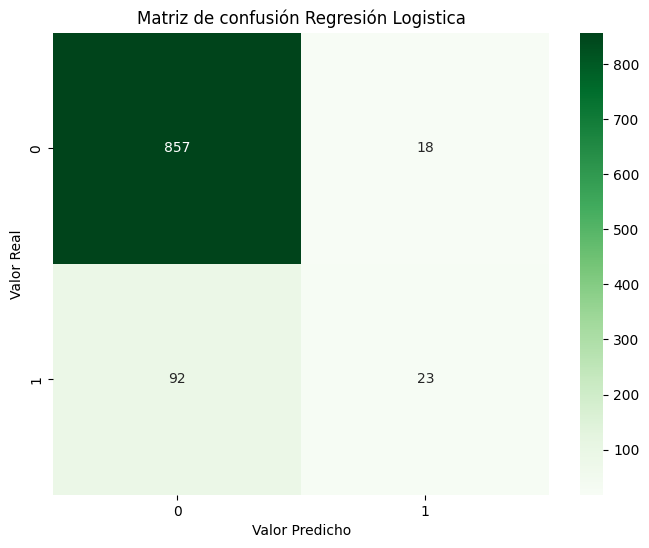

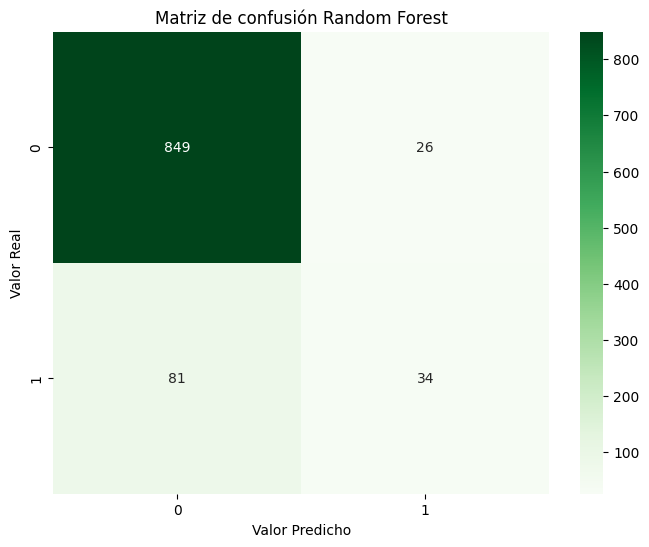

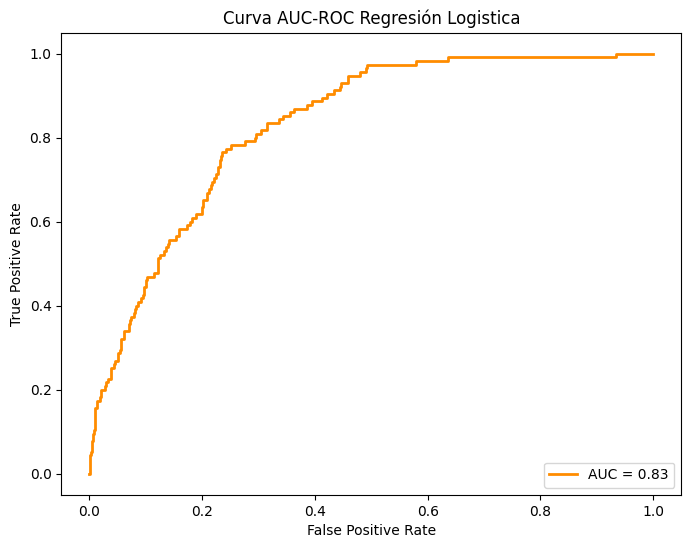

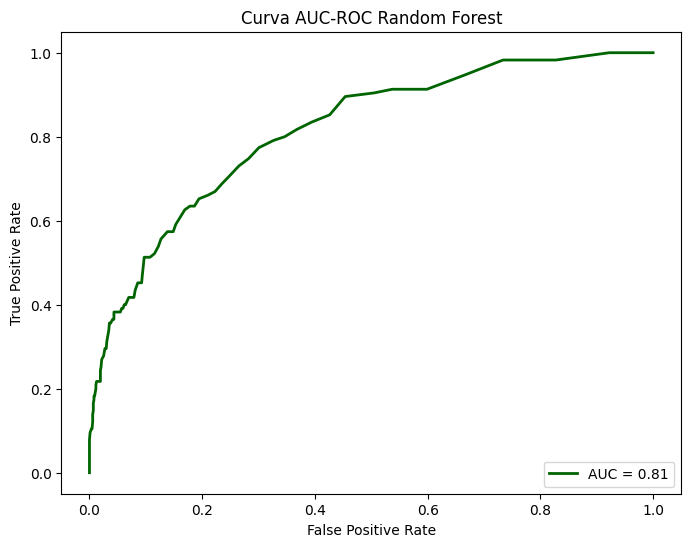

In [8]:
# Métricas de evaluación
print("\n----------Regresión Logistica----------")
print(f"Accuary: {metrics.accuracy_score(y_test, y_predLog):.2%}")
print(f"Precision: {metrics.precision_score(y_test, y_predLog)*100:.2f}%")
print(f"Recall: {metrics.recall_score(y_test, y_predLog)*100:.2f}%")
print(f"Confusion Matrix:\n{metrics.confusion_matrix(y_test, y_predLog)}")
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_predLog).ravel()
print(f"Specificity: {(tn / (tn + fp))*100:.2f}%")
print(f"AUC-ROC: {metrics.roc_auc_score(y_test, y_prob_regrlog)*100:.2f}%")
print("\n")

print("\n------------------Random Forest -----------------------")
print(f"Accuary: {metrics.accuracy_score(y_test, y_pred2):.2%}")
print(f"Precision: {metrics.precision_score(y_test, y_pred2):.2%}")
print(f"Recall: {metrics.recall_score(y_test, y_pred2):.2%}")
print(f"Confusion Matrix:\n{metrics.confusion_matrix(y_test, y_pred2)}")
tn2, fp2, fn2, tp2 = metrics.confusion_matrix(y_test, y_pred2).ravel()
print(f"Specificity: {tn2 / (tn2 + fp2):.2%}")
print(f"AUC-ROC: {metrics.roc_auc_score(y_test, y_prob_RandFor):.2%}")
print("\n")

# Gráficas de matrices de confusión
# Matriz de confusión para regresión logistica
confusion_matrix = metrics.confusion_matrix(y_test, y_predLog)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, cmap="Greens", annot=True, fmt="d")
plt.title("Matriz de confusión Regresión Logistica")
plt.ylabel("Valor Real")
plt.xlabel("Valor Predicho")
plt.show()

# Matriz de confusión para random forest
confusion_matrix = metrics.confusion_matrix(y_test, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, cmap="Greens", annot=True, fmt="d")
plt.title("Matriz de confusión Random Forest")
plt.ylabel("Valor Real")
plt.xlabel("Valor Predicho")

# Graficas de AUC-ROC
# Calcular la curva AUC-ROC para Regresión Logistica
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob_regrlog)
roc_auc = metrics.auc(fpr, tpr)

# Calcular la curva AUC-ROC para Random Forest
fprRF, tprRF, thresholdsRF = metrics.roc_curve(y_test, y_prob_RandFor)
roc_aucRF = metrics.auc(fprRF, tprRF)

# Graficar la curva AUC-ROC para regresión logistica
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva AUC-ROC Regresión Logistica")
plt.legend(loc="lower right")
plt.show()

# Graficar la curva AUC-ROC para random forest
plt.figure(figsize=(8, 6))
plt.plot(fprRF, tprRF, color="darkgreen", lw=2, label=f"AUC = {roc_aucRF:.2f}")
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva AUC-ROC Random Forest")
plt.legend(loc="lower right")
plt.show()